In [1]:
from datetime import date
from glob import glob
import json
import os
from pathlib import Path
import pickle
import sys
import time

from matplotlib import animation
from matplotlib.colorbar import Colorbar
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import mplcursors
import numpy as np
import pandas as pd
from scipy import interpolate, signal, stats, fftpack, ndimage

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import get_evoked_traces, get_events_wdict, find_nearest_ind

In [5]:
%matplotlib widget

# Load experiment

In [6]:
data_dir = Path(r"P:\\")
subject_csv = Path(r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\subject_metadata.csv")
all_subexp = pd.read_csv(subject_csv)
all_subexp.head()

,mouse,sex,DOB,strain,exp_folder,histology,EEG,stim_tip_distance,tiparea,dist_CL,color
0,mouse771424,F,NaN,C57BL/6J,THstim_d1_2024-11-14_11-28-16,True,False,300,TH,0.925338,tomato
1,mouse771424,F,NaN,C57BL/6J,THstim_d2_2024-11-15_10-51-49,True,False,300,CP,1.494992,firebrick
2,mouse771425,F,NaN,C57BL/6J,THstim_d1_2024-11-21_10-59-24,True,False,300,PAL,1.286954,limegreen
3,mouse771425,F,NaN,C57BL/6J,THstim_d2_2024-11-22_10-49-58,True,False,300,int,1.435270,forestgreen
4,mouse771426,M,NaN,C57BL/6J,THstim_d1_2024-12-19_12-19-39,True,False,100,AV,0.686477,violet


# Test on one session

In [7]:
choose_sub = 7
exprow = all_subexp.iloc[choose_sub]
data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)

Experiment type: electrical stimulation


In [8]:
plotsavedir = os.path.join(r'C:\Users\lesliec\OneDrive - Allen Institute\analysis\THstim_project', 'mouse' + exp.mouse)
if not os.path.exists(plotsavedir):
    os.mkdir(plotsavedir)

exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]
print(exp_tag)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\lesliec\\OneDrive - Allen Institute\\data\\plots\\THstim_project\\mouse771427'

Get coords for stim electrode

In [ ]:
stim_elec_file = os.path.join(exp.data_folder, r'stim_elec_location.json')
if os.path.exists(stim_elec_file):
    with open(stim_elec_file) as elec_file:
        stim_elec_data = json.load(elec_file)
else:
    print('Stim electrode location file not found.')

In [ ]:
stim_elec_data

## Load other data

### Load stim log and simple log

In [ ]:
if exp.stimulus_log_file:
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
else:
    print('No stim log found.')

In [ ]:
simple_log_file = exp.stimulus_log_file[:exp.stimulus_log_file.find('estim_log')] + 'simple_' + exp.stimulus_log_file[exp.stimulus_log_file.find('estim_log'):]
if os.path.exists(simple_log_file):
    simple_log = pd.read_csv(simple_log_file)
elif os.path.exists(os.path.join(exp.data_folder, r'simple_estim_log.csv')):
    simple_log = pd.read_csv(os.path.join(exp.data_folder, r'simple_estim_log.csv'))
else:
    print('No simple log found')

In [ ]:
simple_log.head()

### Load pupil diameter, if it exists

In [ ]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    pupil_file = glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0]
    pupildf = pd.read_csv(pupil_file)
  
    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    ## smooth pupil diameter, then normalize ##
    sm_pupil = np.zeros_like(pupilD)
    k = 5 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        sm_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    sm_pupil[:k] = pupilD[:k]
    sm_pupil[-k-1:] = pupilD[-k-1:]
    pupil = sm_pupil / np.mean(pupildf.Eye_Diameter.values)
    print('{:d}% of frames do not have good pupil measurements'.format(int((np.sum(np.isnan(pupilD)) / len(pupilD)) * 100)))
else:
    print('No local Pupileye*.csv file. Check server.')

In [ ]:
np.mean(pupildf.Eye_Diameter.values)

### Load running

In [ ]:
running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

### Load isoflurane signal

In [ ]:
iso_level, isots = exp.load_analog_iso()
iso_induction, iso_maintenance = exp.load_iso_times()
print(iso_induction[0])
iso_level = iso_level - np.mean(iso_level[isots < iso_induction[0]])

In [ ]:
awake_pupil_mean = np.nanmean(sm_pupil[pupilts < iso_induction[0]])
awake_pupil_std = np.nanstd(sm_pupil[pupilts < iso_induction[0]])

### Load unit data

In [ ]:
fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
if os.path.exists(fn_units_info):
    unit_info = pd.read_csv(fn_units_info)
    with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
        all_unit_all_spikes = pickle.load(unit_file)
else:
    print('{} not found. Not analyzing this subject.'.format(fn_units_stats))

unit_info.head()

Plot some of the quality metrics for all cells. The following are used by the AllenSDK:
<br> -  ISI violations (default < 0.5 
<br> -   amplitude cutoff (default < 0. 
<br> -    presence ratio (default > 0.9) * don't typically use this oneow,

## Loop through all units to get spontaneous firing rates

In [ ]:
deltat = 10. # window size, s
awakebins = np.arange(isots[0], iso_induction[0], deltat)
firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)

Get mean speed within the time bins

In [ ]:
tempsp = []
for x in awakebins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
awakespeeds = np.array(tempsp)[:-1]

tempsp = []
for x in isobins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
isospeeds = np.array(tempsp)[:-1]

Loop through units

In [ ]:
restFR = []
runFR = []
isoFR = []
restBR = []
runBR = []
isoBR = []
for unitind, unitrow in unit_info.iterrows():
    uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
    ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
    ## Awake ##
    Aspikec, edges = np.histogram(uspikes, awakebins)
    restFR.append(np.mean(Aspikec[awakespeeds == 0] / deltat))
    runFR.append(np.mean(Aspikec[awakespeeds > 1] / deltat))
    Aburstc, edges = np.histogram(ubursts, awakebins)
    restBR.append(np.mean(Aburstc[awakespeeds == 0] / deltat))
    runBR.append(np.mean(Aburstc[awakespeeds > 1] / deltat))
    ## Isoflurane ##
    Ispikec, edges = np.histogram(uspikes, isobins)
    isoFR.append(np.mean(Ispikec[isospeeds == 0] / deltat))
    Iburstc, edges = np.histogram(ubursts, isobins)
    isoBR.append(np.mean(Iburstc[isospeeds == 0] / deltat))

unit_info['rest_FR'] = restFR
unit_info['run_FR'] = runFR
unit_info['iso_FR'] = isoFR
unit_info['rest_BR'] = restBR
unit_info['run_BR'] = runBR
unit_info['iso_BR'] = isoBR

In [ ]:
unit_info.head()

Plot

In [ ]:
## Subselect units to remove low spiking ones ##
select_units = unit_info[unit_info['spike_count'] > 500]
print(len(select_units))
parent_regions = np.unique(select_units['parent_region'].values)

Plot firing rates

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

comps = {'rest': ['blue'], 'run': ['green'], 'iso': ['red']}
xlocs = np.arange(len(parent_regions) * (len(comps) + 1)).reshape((len(parent_regions), -1))

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = select_units[select_units['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    for jj, (statei, sinfo) in enumerate(comps.items()):
        yvals = np.log10(regidf[statei + '_FR'].values + 1E-3)
        xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
            medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
        )
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylabel('log10(firing rate)')
ax.set_title('Spontaneous firing rates across all areas')

leggies = []
for statei, sinfo in comps.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies)

Plot burst rates

In [ ]:
fig, ax = plt.subplots(figsize=(8,4), constrained_layout=True)

comps = {'rest': ['blue'], 'run': ['green'], 'iso': ['red']}
xlocs = np.arange(len(parent_regions) * (len(comps) + 1)).reshape((len(parent_regions), -1))

rlabels = []
for ii, pregi in enumerate(parent_regions):
    regidf = select_units[select_units['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yval_list = []
    xlist = []
    for jj, (statei, sinfo) in enumerate(comps.items()):
        yvals = np.log10(regidf[statei + '_BR'].values + 1E-3)
        yval_list.append(yvals)
        xlist.append(xlocs[ii, jj])
        # xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
            medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
        )
        # ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
    ax.plot(np.array(xlist), np.array(yval_list), color='k', linewidth=0.5, alpha=0.2)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylabel('log10(burst rate)')
ax.set_title('Spontaneous burst rates across all areas')

leggies = []
for statei, sinfo in comps.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies)

## Investigate some single units

In [ ]:
regi_unitdf = unit_info[unit_info['parent_region'] == 'MO']
print(len(regi_unitdf))
print(np.unique(regi_unitdf['region'].values))
regi_unitdf.head()

In [ ]:
unitind = 625
unitrow = unit_info.iloc[unitind]
print('Unit {}, {}: spike duration={:.2f}, spike count={:d}'.format(unitrow.unit_id, unitrow.region, unitrow.spike_duration, unitrow.spike_count))

In [ ]:
uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
print(len(uspikes))
ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
print(len(ubursts))

In [ ]:
time_bin = 0.005 # size of time bins (s)
totalFR_bins = np.arange(uspikes[0], uspikes[-1], time_bin)
spikets = totalFR_bins[:-1] + time_bin/2
print(len(spikets))

In [ ]:
spcounts, edges = np.histogram(uspikes, totalFR_bins)
burstcounts, edges = np.histogram(ubursts, totalFR_bins)
SDF = ndimage.gaussian_filter(spcounts, sigma=20, output=float) / time_bin
BDF = ndimage.gaussian_filter(burstcounts, sigma=20, output=float) / time_bin

Gaussian kernel length: Butovas&Schwarz2003 use short kernel (sigma=5) for first excitatory response and a long kernel (sigma=50) for rest of response.

In [ ]:
fig, axs = plt.subplots(2, 1, figsize=(11,6), sharex=True, constrained_layout=True)

## Pupil ##
axs[0].axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.1)
axs[0].axhline(awake_pupil_mean, color='b', linewidth=1.0, linestyle='dashed', alpha=0.3)
pupat = mpatches.Rectangle((0, 0), 1, 1, fc='b', alpha=0.1, label='awake pupil')
pup, = axs[0].plot(pupilts, sm_pupil, color='b', alpha=0.8, label='pupil')
axs[0].set_xlim([pupilts[0], pupilts[-1]])
axs[0].set_ylim([-2.5, 100])
axs[0].set_ylabel('Pupil (pixels)', color='b')
axs[0].tick_params(axis='y', colors='b')
## Add stim events ##
for ii, traini in simple_log.iterrows():
    axs[0].axvspan(traini.onset, traini.offset, color='r', alpha=0.2)
spat = mpatches.Rectangle((0, 0), 1, 1, fc='r', alpha=0.2, label='stim train')
## Running ##
runax = axs[0].twinx()
run, = runax.plot(speedts, speed, color='m', alpha=0.8, label='speed')
runax.set_ylabel('Speed (cm/s)', color='m')
runax.tick_params(axis='y', colors='m')
runax.set_ylim([-2.5, 50])
## Iso level ##
isoax = axs[0].twinx()
isoax.spines.right.set_position(("axes", 1.08))
isp, = isoax.plot(isots, iso_level, color='g', alpha=0.8, label='iso')
isoax.set_ylabel('Isoflurane (%)', color='g')
isoax.tick_params(axis='y', colors='g')
## Set title and legend ##
axs[0].set_title('{} - {}: stim elec in {}'.format(exp.mouse, exp_tag, stim_elec_data['tip']['area']))
axs[0].legend(handles = [pup, pupat, run, isp, spat], loc='upper right')

axs[1].plot(spikets, SDF, color='b', linewidth=1.5, alpha=0.6)
axs[1].plot(spikets, BDF, color='c', linewidth=1.5, alpha=0.8)
axs[1].set_xlabel('Time (s)')
axs[1].set_ylabel('Unit {}\nFiring rate (Hz)'.format(unitrow.unit_id))

Create 10 s windows in speed time and divide into rest/run

In [ ]:
deltat = 10. # window size, s

In [ ]:
awakebins = np.arange(isots[0], iso_induction[0], deltat)
Aspikec, edges = np.histogram(uspikes, awakebins)
## Get avg speed in windows ##
tempsp = []
for x in awakebins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
awakespeeds = np.array(tempsp)[:-1]
## Get avg FR in rest/run windows ##
print(np.mean(Aspikec[awakespeeds == 0] / deltat))
print(np.mean(Aspikec[awakespeeds > 1] / deltat))

In [ ]:
Aburstc, edges = np.histogram(ubursts, awakebins)
print(Aburstc)
print(np.mean(Aburstc[awakespeeds == 0] / deltat))
print(np.mean(Aburstc[awakespeeds > 1] / deltat))

Now get iso firing rates

In [ ]:
firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)
Ispikec, edges = np.histogram(uspikes, isobins)
tempsp = []
for x in isobins:
    tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
isospeeds = np.array(tempsp)[:-1]
print(np.mean(Ispikec[isospeeds == 0] / deltat))

In [ ]:
print(isots[0])
print(iso_induction[0])
print(iso_maintenance[0])
print(stim_log.onset.values[0])
print(simple_log.onset.values[0])

## Plot an event

In [ ]:
simple_log

In [ ]:
choose_event = 4
eventrow = simple_log.iloc[choose_event]
print(eventrow)
event_stims = stim_log[stim_log['event_ID'] == choose_event]
event_stims.head()

In [ ]:
plot_regions = ['TH', 'HIP', 'STR', 'VIS', 'SS', 'MO']
umax = 100
pdelta = 10. # plot before and after, s
pwindow = [eventrow.onset - pdelta, eventrow.offset + pdelta]

fig = plt.figure(figsize=(10, 7)) # (10,10)
gs = fig.add_gridspec(ncols=1, nrows=2, left=0.06, right=0.98, top=0.95, bottom=0.08, hspace=0.05, height_ratios=[1,5])
aax = fig.add_subplot(gs[0])
rasterax = fig.add_subplot(gs[1], sharex=aax)

## Plot pupil ##
pupilinds = np.nonzero((pupilts > pwindow[0]) & (pupilts < pwindow[1]))[0]
aax.axvspan(eventrow.onset, eventrow.offset, color='g', alpha=0.05)
# aax.axhspan(awake_pupil_mean - awake_pupil_std, awake_pupil_mean + awake_pupil_std, color='b', alpha=0.05)
# aax.axhline(awake_pupil_mean, color='b', linestyle='dashed', alpha=0.2)
for si, stimi in event_stims.iterrows():
    aax.axvline(stimi.onset, color='g', linewidth=0.5, alpha=0.2)
aax.plot(pupilts[pupilinds], sm_pupil[pupilinds])
aax.set_xlim(pwindow)
# aax.set_xlabel('Time (s)')
aax.set_ylabel('Pupil size (pixels)')

## Plot raster ##
last_ind = 0
regb = [last_ind]
for ii, pregi in enumerate(plot_regions):
    regdf = unit_info[unit_info['parent_region'] == pregi].sort_values(by='depth', ascending=False).reset_index(drop=True)
    if len(regdf) > umax:
        punitinds = np.random.choice(range(len(regdf)), size=umax, replace=False)
    else:
        punitinds = range(len(regdf))
    for indi in punitinds:
        urow = regdf.iloc[indi]
        uspiketimes = all_unit_all_spikes[urow.unit_id]['spikes']
        SWDspikes = uspiketimes[
            np.nonzero((uspiketimes > pwindow[0]) & (uspiketimes < pwindow[1]))[0]
        ]
        rasterax.eventplot(SWDspikes, lineoffsets=last_ind, linelengths=1.0, color='black', alpha=0.8)
        last_ind += 1
    rasterax.annotate(
        '{}'.format(pregi), xy=(pwindow[0], last_ind - len(punitinds)/2), xycoords='data',
        annotation_clip=False, rotation=20, ha='right', va='center', fontsize=9
    )
    last_ind += 2
    regb.append(last_ind - 1)
    rasterax.axhline(last_ind - 1, color='m', alpha=0.2)

rasterax.set_ylim(-1, last_ind)
rasterax.set_xlim(pwindow)
rasterax.set_xlabel('Time (s)')
rasterax.set_yticks(regb)
rasterax.set_yticklabels([])

### SAVE ###
# fig_name = 'spont_EEG_NPX_{:d}-{:d}s.png'.format(int(window[0]), int(window[1]))
# fig.savefig(os.path.join(plotsavedir, fig_name), transparent=False)

### Load EEG data

In [ ]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_data = eeg_data * 1E-3 # convert to mV
eeg_chs = np.arange(0, eeg_data.shape[1])

bad_chs = []
GOOD_CHS = np.array([x for x in eeg_chs if x not in bad_chs])

In [ ]:
print(eeg_ts[0])
print(eeg_ts[-1])

In [ ]:
bpb, bpa = signal.butter(3, np.array([0.5, 50])/(exp.ephys_params['EEG']['sample_rate']/2), btype='bandpass')
filt_data = signal.filtfilt(bpb, bpa, eeg_data, axis=0)

# Loop through all subjects to plot spontaneous firing rate for all units

In [7]:
deltat = 10. # window size, s

all_unit_info_list = []
for expind, exprow in all_subexp.iterrows():
    ## Load the experiment ##
    data_path = os.path.join(data_dir, exprow.mouse, exprow.exp_folder, 'experiment1', 'recording1')
    exp = EEGexp(data_path, preprocess=False, make_stim_csv=False)
    exp_tag = exprow.exp_folder[:9]
    print('{} - {}'.format(exprow.mouse, exprow.exp_folder))

    ## Load the stim log ##
    if exp.stimulus_log_file:
        stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    else:
        print('No stim log found.\n')
        continue

    ## Load the running ##
    running_file = os.path.join(exp.data_folder, 'raw_running_signal.npy')
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    if os.path.exists(running_file) and os.path.exists(running_ts_file):
        speed = np.load(running_file)
        speedts = np.load(running_ts_file)
    else:
        print('No running files found.\n')
        continue

    ## Load the iso times ##
    iso_level, isots = exp.load_analog_iso()
    iso_induction, iso_maintenance = exp.load_iso_times()

    ## Load unit info ##
    fn_units_info = os.path.join(exp.data_folder, 'all_units_info.csv')
    if os.path.exists(fn_units_info):
        unit_info = pd.read_csv(fn_units_info)
        with open(os.path.join(exp.data_folder, 'units_allspikes.pkl'), 'rb') as unit_file:
            all_unit_all_spikes = pickle.load(unit_file)
    else:
        print('{} not found. Not analyzing this subject.\n'.format(fn_units_stats))
        continue

    ## Print some info about regions ##
    for pregi in np.unique(unit_info['parent_region'].values):
        pudf = unit_info[unit_info['parent_region'] == pregi]
        print('{}: {:d} units'.format(pregi, len(pudf)))
        # print(np.unique([x for x in pudf.region.values if isinstance(x, str)]))

    ## Get time bins for spontaneous times ##
    awakebins = np.arange(isots[0], iso_induction[0], deltat)
    firstind = np.nonzero(stim_log.onset.values > iso_maintenance[0])[0][0]
    isobins = np.arange(iso_maintenance[0], stim_log.onset.values[firstind], deltat)
    print('\nAwake time: {:.2f} s'.format(iso_induction[0] - isots[0]))
    print('Iso time: {:.2f} s'.format(stim_log.onset.values[firstind] - iso_maintenance[0]))

    ## Get the speed ##
    tempsp = []
    for x in awakebins:
        tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
    awakespeeds = np.array(tempsp)[:-1]
    tempsp = []
    for x in isobins:
        tempsp.append(np.mean(speed[np.nonzero((speedts >= x) & (speedts < x + deltat))[0]]))
    isospeeds = np.array(tempsp)[:-1]

    ## Get the mean firing rate for all states and add it to the unit_info df ##
    restFR = []
    runFR = []
    isoFR = []
    restBR = []
    runBR = []
    isoBR = []
    for unitind, unitrow in unit_info.iterrows():
        uspikes = all_unit_all_spikes[unitrow.unit_id]['spikes']
        ubursts = all_unit_all_spikes[unitrow.unit_id]['bursts']
        ## Awake ##
        Aspikec, edges = np.histogram(uspikes, awakebins)
        restFR.append(np.mean(Aspikec[awakespeeds == 0] / deltat))
        runFR.append(np.mean(Aspikec[awakespeeds > 1] / deltat))
        Aburstc, edges = np.histogram(ubursts, awakebins)
        restBR.append(np.mean(Aburstc[awakespeeds == 0] / deltat))
        runBR.append(np.mean(Aburstc[awakespeeds > 1] / deltat))
        ## Isoflurane ##
        Ispikec, edges = np.histogram(uspikes, isobins)
        isoFR.append(np.mean(Ispikec[isospeeds == 0] / deltat))
        Iburstc, edges = np.histogram(ubursts, isobins)
        isoBR.append(np.mean(Iburstc[isospeeds == 0] / deltat))
    unit_info['rest_FR'] = restFR
    unit_info['run_FR'] = runFR
    unit_info['iso_FR'] = isoFR
    unit_info['rest_BR'] = restBR
    unit_info['run_BR'] = runBR
    unit_info['iso_BR'] = isoBR
    unit_info['mouse'] = [exprow.mouse] * len(unit_info)
    unit_info['exp'] = [exp_tag] * len(unit_info)

    ## Save the unit df for all sessions ##
    all_unit_info_list.append(unit_info)
    print('\n\n')

all_units_info = pd.concat(all_unit_info_list, ignore_index=True)

Experiment type: electrical stimulation
mouse771424 - THstim_d1_2024-11-14_11-28-16
ACA: 15 units
HIP: 136 units
ILA: 96 units
MB: 43 units
MO: 230 units
OLF: 30 units
PL: 82 units
RHP: 59 units
SS: 312 units
TH: 341 units
VIS: 239 units

Awake time: 575.24 s
Iso time: 1320.55 s



Experiment type: electrical stimulation
mouse771424 - THstim_d2_2024-11-15_10-51-49
ACA: 34 units
HIP: 63 units
ILA: 76 units
MB: 4 units
MO: 358 units
OLF: 63 units
PL: 104 units
SS: 107 units
STR: 11 units
TH: 227 units
VIS: 131 units

Awake time: 734.10 s
Iso time: 915.32 s



Experiment type: electrical stimulation
mouse771425 - THstim_d1_2024-11-21_10-59-24
FRP: 17 units
HIP: 3 units
MB: 68 units
MO: 183 units
OLF: 7 units
ORB: 224 units
RHP: 146 units
SS: 200 units
TH: 322 units
VIS: 134 units

Awake time: 647.96 s
Iso time: 463.13 s



Experiment type: electrical stimulation
mouse771425 - THstim_d2_2024-11-22_10-49-58
FRP: 29 units
HIP: 107 units
MB: 2 units
MO: 364 units
OLF: 140 units
ORB: 462 units

C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\fromnumeric.py:3420: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\lesliec\Miniconda3\envs\tbd_eeg\lib\site-packages\numpy\core\_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)





Experiment type: electrical stimulation
mouse771426 - THstim_d1_2024-12-19_12-19-39
ACA: 60 units
HIP: 37 units
HPF: 33 units
ILA: 34 units
MB: 26 units
MO: 241 units
OLF: 128 units
PL: 80 units
RHP: 76 units
STR: 45 units
TH: 207 units

Awake time: 676.77 s
Iso time: 516.49 s



Experiment type: electrical stimulation
mouse771426 - THstim_d2_2024-12-20_09-28-35
ACA: 107 units
HIP: 74 units
HPF: 7 units
ILA: 156 units
MB: 4 units
MO: 269 units
OLF: 307 units
PL: 90 units
RHP: 94 units
SS: 17 units
STR: 123 units
TH: 133 units
VIS: 1 units

Awake time: 683.53 s
Iso time: 1334.05 s



Experiment type: electrical stimulation
mouse771427 - THstim_d1_2025-01-22_10-36-51
HIP: 75 units
MB: 63 units
MO: 172 units
RHP: 100 units
SS: 17 units
STR: 109 units
TH: 158 units
VIS: 115 units

Awake time: 703.67 s
Iso time: 449.70 s



Experiment type: electrical stimulation
mouse771427 - THstim_d2_2025-01-23_10-25-10
ACA: 6 units
HIP: 57 units
HPF: 11 units
MB: 63 units
MO: 75 units
RHP: 46 units
S

In [8]:
all_units_info.head()

,unit_id,probe,peak_ch,depth,spike_duration,region,CCF_AP,CCF_DV,CCF_ML,firing_rate,presence_ratio,isi_viol,amplitude_cutoff,spike_count,parent_region,rest_FR,run_FR,iso_FR,rest_BR,run_BR,iso_BR,mouse,exp
0,A0,probeA,1,2800,0.329648,DP,148,175,206,3.243251,0.96,0.490643,0.044419,16959,OLF,2.8250,15.154762,1.284733,0.0750,0.123810,0.002290,mouse771424,THstim_d1
1,A1,probeA,1,2800,0.590620,DP,148,175,206,0.779306,0.98,1.416315,0.033073,4075,OLF,0.7875,0.290476,1.068702,0.0000,0.000000,0.000000,mouse771424,THstim_d1
2,A2,probeA,2,2780,0.604355,DP,148,174,205,2.336579,0.94,0.144420,0.006039,12218,OLF,4.8625,9.809524,1.584733,0.0000,0.004762,0.001527,mouse771424,THstim_d1
3,A3,probeA,5,2760,0.686767,DP,148,173,205,3.301006,0.98,1.394562,0.318508,17261,OLF,11.4375,11.026190,2.123664,0.0875,0.145238,0.010687,mouse771424,THstim_d1
4,A4,probeA,6,2740,0.315913,DP,148,173,205,3.641414,0.98,0.562196,0.282281,19041,OLF,9.0625,17.121429,2.507634,0.1250,0.211905,0.007634,mouse771424,THstim_d1


In [9]:
print(len(all_units_info))

10695


### Plot all units

In [10]:
plotdir = r"C:\Users\lesliec\OneDrive - Allen Institute\Shared Documents - Lab 328\Projects\CL-CM stim\pictures and plots"

In [11]:
## Subselect units to remove low spiking ones ##
all_select_units = all_units_info[all_units_info['spike_count'] > 500]
print(len(all_select_units))

8787


In [12]:
print(np.unique(all_select_units['parent_region'].values))

['ACA' 'FRP' 'HIP' 'HPF' 'ILA' 'MB' 'MO' 'OLF' 'ORB' 'PL' 'RHP' 'SS' 'STR'
 'TH' 'VIS']


#### Firing rate

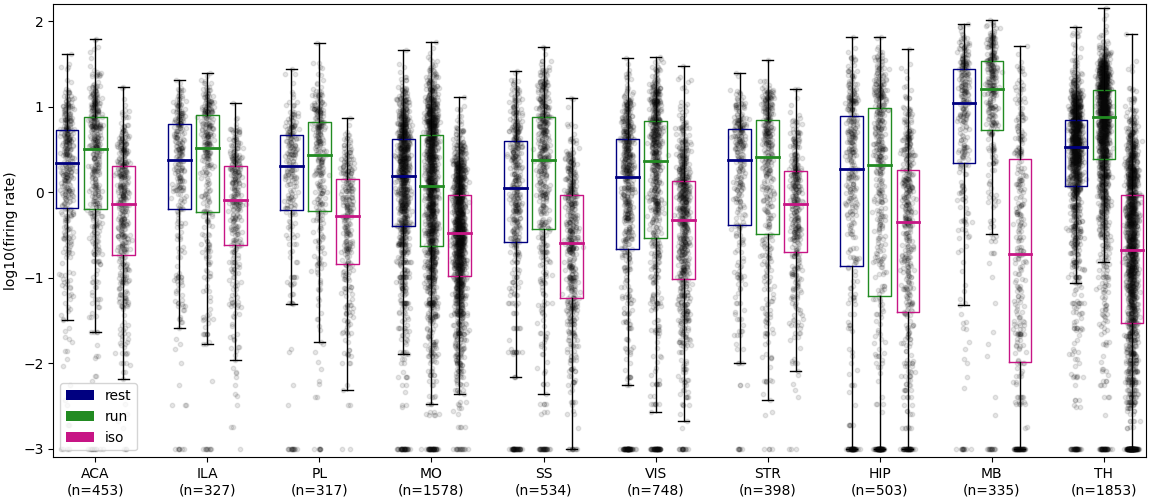

In [21]:
# plot_regions = ['ACA', 'ILA', 'PL', 'OLF', 'ORB', 'MO', 'SS', 'VIS', 'STR', 'HIP', 'MB', 'TH']
plot_regions = ['ACA', 'ILA', 'PL', 'MO', 'SS', 'VIS', 'STR', 'HIP', 'MB', 'TH']

fig, ax = plt.subplots(figsize=(11.5,5), constrained_layout=True)

comps = {'rest': ['navy'], 'run': ['forestgreen'], 'iso': ['mediumvioletred']}
xlocs = np.arange(len(plot_regions) * (len(comps) + 1)).reshape((len(plot_regions), -1))

rlabels = []
for ii, pregi in enumerate(plot_regions):
    regidf = all_select_units[all_select_units['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    for jj, (statei, sinfo) in enumerate(comps.items()):
        FRs = regidf[statei + '_FR'].values
        yvals = np.log10(FRs[~np.isnan(FRs)] + 1E-3)
        xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
            medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
        )
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylabel('log10(firing rate)')
# ax.set_title('Spontaneous firing rates across all sessions and areas')
ax.set_ylim([-3.1, 2.2])

leggies = []
for statei, sinfo in comps.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies, loc='lower left')

## Save ##
figname = 'allsessions_some_spontFR_BS{}.png'.format(date.today().strftime('%b%d%Y'))
# fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

#### Burst rate

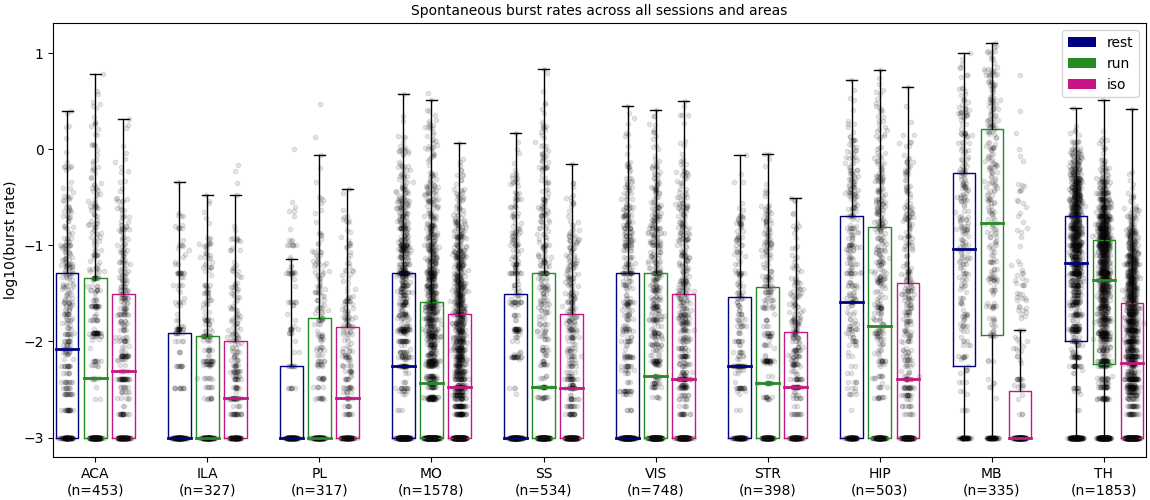

In [16]:
# plot_regions = ['ACA', 'ILA', 'PL', 'OLF', 'ORB', 'MO', 'SS', 'VIS', 'STR', 'HIP', 'MB', 'TH']
plot_regions = ['ACA', 'ILA', 'PL', 'MO', 'SS', 'VIS', 'STR', 'HIP', 'MB', 'TH']

fig, ax = plt.subplots(figsize=(11.5,5), constrained_layout=True)

comps = {'rest': ['navy'], 'run': ['forestgreen'], 'iso': ['mediumvioletred']}
xlocs = np.arange(len(plot_regions) * (len(comps) + 1)).reshape((len(plot_regions), -1))

rlabels = []
for ii, pregi in enumerate(plot_regions):
    regidf = all_select_units[all_select_units['parent_region'] == pregi]
    rlabels.append('{}\n(n={:d})'.format(pregi, len(regidf)))
    yval_list = []
    # xlist = []
    for jj, (statei, sinfo) in enumerate(comps.items()):
        BRs = regidf[statei + '_BR'].values
        yvals = np.log10(BRs[~np.isnan(BRs)] + 1E-3)
        xs = np.random.normal(xlocs[ii, jj], 0.1, len(yvals))
        yval_list.append(np.log10(BRs + 1E-3))
        # xlist.append(xlocs[ii, jj])
        ax.boxplot(
            yvals, positions=[xlocs[ii, jj]], widths=[0.8], showfliers=False,
            medianprops={'color': sinfo[0], 'linewidth': 2}, boxprops={'color': sinfo[0]}
        )
        ax.scatter(xs, yvals, c='k', marker='o', s=10, alpha=0.1)
    # ax.plot(np.array(xlist), np.array(yval_list), color='k', linewidth=0.5, alpha=0.1)
ax.set_xticks(np.mean(xlocs[:,:-1], axis=1))
ax.set_xticklabels(rlabels)
ax.set_ylabel('log10(burst rate)')
ax.set_title('Spontaneous burst rates across all sessions and areas')

leggies = []
for statei, sinfo in comps.items():
    leggies.append(mpatches.Rectangle((0, 0), 1, 1, fc=sinfo[0], label=statei))
ax.legend(handles=leggies)

## Save ##
figname = 'allsessions_allunits_spontburstrate_dots_{}.png'.format(date.today().strftime('%b%d%Y'))
fig.savefig(os.path.join(plotdir, figname), transparent=False, dpi=150)

In [15]:
np.array(xlist)

array([0, 1, 2])

In [20]:
bugs = np.array(yval_list)

In [23]:
print(np.sum(np.isnan(bugs[1,:])))

0
